# 决策树
类似于编程过程中的if/else，在多个决策模块进行处理后，最终到达一个终止模块，得出分类的类别。

## 1 决策树的构造
首先我们讨论数学上如何运用**信息论**划分数据集，然后将理论应用到具体数据集上，最后构造决策树。

分析一个问题时，需要找到哪个特性对于划分起到了决定性的作用，所以先要评估每个特征，找出决定性的特征。

完成评估后，数据就会被划分成几个数据子集，这些数据子集会分布在第一个决策点的所有分支，如果某个分支下的所有数据属于同一类型，则一个分类完成，否则进一步进行划分，一直迭代直到所有的相同类型的数据都划分在一个数据子集内。

有些决策树使用二分法划分数据，这里我们使用[ID3](https://en.wikipedia.org/wiki/ID3_algorithm)算法划分数据集。每次划分数据我们只选取一个特征属性，那么如何决定第一个特征呢？

### 1.1 信息增益
* *信息增益* -- *Information Gain*
* *熵* -- *Entropy*

“熵”定义为信息的期望值，如果待分类的事物可能划分在多个分类中，符号x的信息定义为
$$l(x_i) = -\log_2p(x_i)$$

所以计算所有类别所有可能值包含的信息期望值，就是
$$Ent(D) = -\sum_{i=1}^{n}p(x_i)\log_2p(x_i)$$

下面通过代码来实现熵的计算

In [1]:
import numpy as np

In [2]:
def CalcEnt(dataSet):
    total_num = len(dataSet)
    # 先找到总共有多少类别，将每个类别作为键值放到字典中
    labels = {}
    for data in dataSet:
        current_label = data[-1]
        if current_label not in labels.keys():
            labels[current_label] = 0
        labels[current_label] += 1
        
    Ent = 0.0
    for key in labels:
        p = labels[key] / float(total_num)
        Ent -= p * np.log2(p)
        
    return Ent

In [3]:
dataSet = [[1, 1, 'yes'], [1, 1, 'yes'], [1, 0, 'no'], [0, 1, 'no'], [0, 1, 'no']]

In [4]:
CalcEnt(dataSet)

0.97095059445466858

上面例子中，n=2（只有yes/no两个类），
$$Ent(D) = - \frac{2}{5}\log_2\frac{2}{5} - \frac{3}{5}\log_2\frac{3}{5} = 0.97095$$
熵越高，代表分类越多，数据混合越多。
___
*信息增益*是指划分数据之后的变化，是能够让熵减小的效果。公式为
$$Gain(D, f) = Ent(D) - \sum^{V}_{v=1}\frac{|D^v|}{|D|}Ent(D^v)$$
$|D|$表示样本D的个数，$|D^v|$表示特征$f$中的一个类$v$的个数。

拿上面的数据举例，$|D| = 5$，如果我们看第一个特征，也就是[1, 1, 1, 0, 0]这5个样本，这5个样本共有2个分类，我们说$|D^0| = 2$，$|D^1| = 3$，而$Ent(D^v)$这个值就是在（假设$Ent(D^1)$）3个样本里面计算取值为1时，yes/no的熵。

### 1.2 划分数据
我们将每个特征划分数据集的结果计算一次信息熵，然后判断哪个是最好的划分。

In [7]:
num_features = len(dataSet[0]) - 1
ent_D = CalcEnt(dataSet)
# 第0个特征，f0; 取值0，1
f0_D0 = [data for data in dataSet if data[0] == 0]
f0_D1 = [data for data in dataSet if data[0] == 1]
ent_D0 = CalcEnt(f0_D0)
ent_D1 = CalcEnt(f0_D1)
prob0 = len(f0_D0) / float(len(dataSet))
prob1 = len(f0_D1) / float(len(dataSet))
gain0 = ent_D - (prob0 * ent_D0 + prob1 * ent_D1)
# 第1个特征，f1; 取值0，1
f1_D0 = [data for data in dataSet if data[1] == 0]
f1_D1 = [data for data in dataSet if data[1] == 1]
ent_D0 = CalcEnt(f1_D0)
ent_D1 = CalcEnt(f1_D1)
prob0 = len(f1_D0) / float(len(dataSet))
prob1 = len(f1_D1) / float(len(dataSet))
gain1 = ent_D - (prob0 * ent_D0 + prob1 * ent_D1)

In [8]:
gain0, gain1

(0.41997309402197491, 0.17095059445466854)

从上面可以看出第0个特征值的信息增益大，也就是说这个特征对结果的影响大。下面重构一下以上代码。

分两个步骤，第一步将数据按照某个特征进行假设划分，第二步再计算按照这种划分方式得到的信息增益，进而选择最好的划分特征。  
上面例子中获取f0_D0就是在划分数据

In [9]:
def SplitDataSet(DataSet, Feature, Value):
    '''
    Feature：需要划分的特征
    Value：该特征按照Value进行划分
    '''
    SplitData = []
    for data in DataSet:
        if data[Feature] == Value:
            tempData = data[:Feature]
            tempData.extend(data[Feature+1:])
            SplitData.append(tempData)
    return SplitData

In [10]:
dataSet

[[1, 1, 'yes'], [1, 1, 'yes'], [1, 0, 'no'], [0, 1, 'no'], [0, 1, 'no']]

In [11]:
SplitDataSet(dataSet, 0, 1)

[[1, 'yes'], [1, 'yes'], [0, 'no']]

In [16]:
def ChooseBestFeature(D):
    num_features = len(D[0]) - 1
    num_examples = len(D)
    ent_D = CalcEnt(D)
    gain = []
    # 对每个特征进行处理
    for index_feature in range(num_features):
        # 获取该特征的所有不重复值
        values_feature = [data[index_feature] for data in D]
        values = set(values_feature)
        gain_f = ent_D
        # 对每个取值进行分类
        for v in values:
            Dv = SplitDataSet(D, index_feature, v)
            prob = len(Dv) / float(num_examples)
            ent_Dv = CalcEnt(Dv)
            gain_f -= prob * ent_Dv
        gain.append(gain_f)
    return gain.index(max(gain))

In [17]:
ChooseBestFeature(dataSet)

0

### 1.3 递归构建决策树
得到一组数据后，基于最好的特征进行划分，将划分特征的数据集作为上一次划分的原始数据，对剩下的特征再次进行划分。结束的条件是：
- 程序遍历完所有的属性
- 每个分支下的所有实例都属于相同的分类，这种情况产生一个叶节点

以上面的数据为例，
<table>
    <tr><td/><td>Feature0</td><td>Feature1</td><td>Label</td></tr>
    <tr><td>1</td><td>1</td><td>1</td><td>yes</td></tr>
    <tr><td>2</td><td>1</td><td>1</td><td>yes</td></tr>
    <tr><td>3</td><td>1</td><td>0</td><td>no</td></tr>
    <tr><td>4</td><td>0</td><td>1</td><td>no</td></tr>
    <tr><td>5</td><td>0</td><td>1</td><td>no</td></tr>
</table>

确定了第0个特征划分后，以F0为基础数据，进行划分。

F0有两个取值0/1，如果取0，则得到的都在no这一类中，满足所有实例属于相同分类的条件，直接产生叶节点，并且值为no。

如果取1，则有yes, yes, no这些结果，分别是1、2、3的实例。下面继续在这3个实例中寻找最佳划分，结果是F1，实际上也只有这一个特征了。
同样的方法，F1也有两个取值，取0全为no，取1全为yes，则决策树构造完成。

In [18]:
from collections import Counter
features = ["F0", "F1"]
tree = {}

In [97]:
def CreateNode(D, Labels):
    
    # 所有特征都遍历过了，也就是说剩下的只有labels了
    if len(D[0]) == 1:
        cnt = Counter([d[0] for d in D])
        return cnt.most_common()[0][0]

    # 该分支下所有类别都是同一个类
    labels = set([data[-1] for data in D])
    if len(labels) == 1:
        return list(labels)[0]

    # 还需要继续划分树
    bestFeature = ChooseBestFeature(D)
    bestLabels = Labels[bestFeature]
    Node = {bestLabels: {}}
    del(Labels[bestFeature])
    featureValues = set([data[bestFeature] for data in D])
    for value in featureValues:
        subLabels = Labels[:]
        Node[bestLabels][value] = CreateNode(SplitDataSet(D, bestFeature, value), subLabels)
    return Node

In [98]:
tree = CreateNode(dataSet, ['no surfacing', 'flippers'])

In [99]:
tree

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}

## 2 决策树的绘制

上面的决策树使用字典的形式，不容易直观看出树的结构，下面将使用绘图的方式表达决策树

### 2.1 基本绘图 annotate注解  
matplotlib提供了一个库函数[annotate](https://matplotlib.org/users/annotations.html)，此函数功能是对图形中具体内容通过箭头进行注解，这里利用这个功能作为树的基本结构

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

In [103]:
# 定义文本框 和 箭头格式
# sawtooth 波浪方框, round4 矩形方框 , fc表示字体颜色的深浅 0.1~0.9 依次变浅
decisionNode = {'boxstyle': 'sawtooth', 'fc': '0.8'}
leafNode = {'boxstyle': 'round4', 'fc': '0.8'}
arrowArgs = {'arrowstyle': '<-'}


def PlotNode(NodeText, CurrentPtr, ParentPtr, NodeType):
    CreatePlot.ax1.annotate(NodeText, xy=ParentPtr, xycoords='axes fraction',
            xytext=CurrentPtr, textcoords='axes fraction',
            va='center', ha='center', bbox=NodeType, arrowprops=arrowArgs)

def PlotMidText(Text, CurrentPtr, ParentPtr):
    x = (CurrentPtr[0] + ParentPtr[0]) / 2.0
    y = (CurrentPtr[1] + ParentPtr[1]) / 2.0
    CreatePlot.ax1.text(x, y, Text)
                                                                
def CreatePlot(Tree=None):
    fig = plt.figure(1, facecolor='white')
    fig.clf()
    
    if Tree is not None:
        CreatePlot.ax1 = plt.subplot(111, frameon=False)
        
        PlotTree.totalX = GetLeafNum(Tree)
        PlotTree.totalY = GetTreeDepth(Tree)
        PlotTree.xOff = -0.5 / PlotTree.totalX
        PlotTree.yOff = 1.0
    
        PlotTree(Tree, (0.5, 1.0), '')
    else:
        CreatePlot.ax1 = plt.subplot(111, frameon=False)
        currentPtr1 = (0.5, 0.1)
        parentPtr1 = (0.1, 0.5)
        currentPtr2 = (0.8, 0.1)
        parentPtr2 = (0.3, 0.8)
        PlotNode('Decision Node', currentPtr1, parentPtr1, decisionNode)
        PlotNode('Leaf Node', currentPtr2, parentPtr2, leafNode)
        PlotMidText('0', currentPtr1, parentPtr1)
        PlotMidText('1', currentPtr2, parentPtr2)

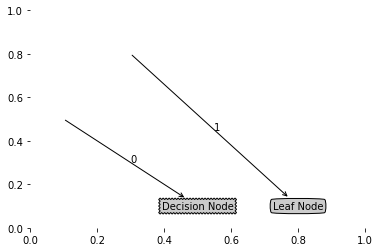

In [51]:
CreatePlot()

### 2.2 确认树的深度和叶节点个数  
要确认x轴的长度，就要知道叶子节点的个数，要确认y轴的长度，就要知道树的深度。

In [47]:
def GetLeafNum(Tree):
    LeafNum = 0
    for node in Tree.values():
        if type(node) is dict:
            LeafNum += GetLeafNum(node)
        else:
            LeafNum += 1
    return LeafNum

def getTreeDictDepth(Tree):
    Depth = 0
    for node in Tree.values():
        if type(node) is dict:
            nodeDepth = 1 + getTreeDictDepth(node)
        else:
            nodeDepth = 1
        Depth = max(nodeDepth, Depth)
    return Depth
    
def GetTreeDepth(Tree):
    return getTreeDictDepth(Tree) / 2 + 1

In [49]:
GetLeafNum(tree), GetTreeDepth(tree)

(3, 3)

### 2.3 绘制决策树

In [87]:
def PlotTree(Tree, ParentPtr, NodeText):
    leafNum = GetLeafNum(Tree)
    treeDepth = GetTreeDepth(Tree)
    
    # Find center position
    xUnit = 1.0 / PlotTree.totalX
    yUnit = 1.0 / PlotTree.totalY
    centerPtr = (PlotTree.xOff + (1 + leafNum) / 2.0 * xUnit, PlotTree.yOff)
    print centerPtr
    
    # 绘制自身节点之前，先绘制箭头指向父节点
    PlotMidText(NodeText, centerPtr, ParentPtr)
    
    # 绘制自身节点
    firstStr = list(Tree.keys())[0]
    PlotNode(firstStr, centerPtr, ParentPtr, decisionNode)
    
    # 递归树结构
    subTree = Tree[firstStr]
    PlotTree.yOff -= yUnit
    for key in subTree.keys():
        if type(subTree[key]) is dict:
            PlotTree(subTree[key], centerPtr, str(key))
        else:
            PlotTree.xOff += xUnit
            PlotNode(subTree[key], (PlotTree.xOff, PlotTree.yOff), centerPtr, leafNode)
            PlotMidText(str(key), (PlotTree.xOff, PlotTree.yOff), centerPtr)
            
    PlotTree.yOff += yUnit

(0.5, 1.0)
(0.6666666666666666, 0.6666666666666667)


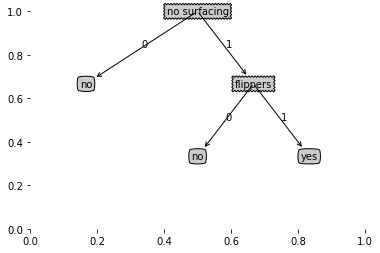

In [104]:
CreatePlot(tree)

In [105]:
tree

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}

## 3 测试决策树

In [107]:
def Predict(Tree, Feature, TestVec):
    firstStr = Tree.keys()[0]
    secondDict = Tree[firstStr]
    featureIndex = Feature.index(firstStr)
    for key in secondDict.keys():
        if TestVec[featureIndex] == key:
            if type(secondDict[key]) is dict:
                Result = Predict(secondDict[key], Feature, TestVec)
            else:
                Result = secondDict[key]
    return Result

In [108]:
Predict(tree, ['no surfacing', 'flippers'], [1, 0])

'no'

In [109]:
Predict(tree, ['no surfacing', 'flippers'], [1, 1])

'yes'

## 4 保存决策树

In [110]:
def StoreTree(Tree, Filename):
    import pickle
    f = open(Filename, 'w')
    pickle.dump(Tree, f)
    f.close()
    
def GrabTree(Filename):
    import pickle
    f = open(Filename, 'r')
    return pickle.load(f)

In [111]:
StoreTree(tree, 'TreeStorage.txt')

In [112]:
GrabTree('TreeStorage.txt')

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}

## 5 示例测试

In [113]:
f = open('lenses.txt')

In [114]:
lenses = [inst.strip().split('\t') for inst in f.readlines()]

In [115]:
lenses

[['young', 'myope', 'no', 'reduced', 'no lenses'],
 ['young', 'myope', 'no', 'normal', 'soft'],
 ['young', 'myope', 'yes', 'reduced', 'no lenses'],
 ['young', 'myope', 'yes', 'normal', 'hard'],
 ['young', 'hyper', 'no', 'reduced', 'no lenses'],
 ['young', 'hyper', 'no', 'normal', 'soft'],
 ['young', 'hyper', 'yes', 'reduced', 'no lenses'],
 ['young', 'hyper', 'yes', 'normal', 'hard'],
 ['pre', 'myope', 'no', 'reduced', 'no lenses'],
 ['pre', 'myope', 'no', 'normal', 'soft'],
 ['pre', 'myope', 'yes', 'reduced', 'no lenses'],
 ['pre', 'myope', 'yes', 'normal', 'hard'],
 ['pre', 'hyper', 'no', 'reduced', 'no lenses'],
 ['pre', 'hyper', 'no', 'normal', 'soft'],
 ['pre', 'hyper', 'yes', 'reduced', 'no lenses'],
 ['pre', 'hyper', 'yes', 'normal', 'no lenses'],
 ['presbyopic', 'myope', 'no', 'reduced', 'no lenses'],
 ['presbyopic', 'myope', 'no', 'normal', 'no lenses'],
 ['presbyopic', 'myope', 'yes', 'reduced', 'no lenses'],
 ['presbyopic', 'myope', 'yes', 'normal', 'hard'],
 ['presbyopic', 

In [116]:
lensesLabels = ['age', 'prescript', 'astigmatic', 'tearRate']

In [117]:
lensesTree = CreateNode(lenses, lensesLabels)

In [118]:
lensesTree

{'tearRate': {'normal': {'astigmatic': {'no': {'age': {'pre': 'soft',
      'presbyopic': {'prescript': {'hyper': 'soft', 'myope': 'no lenses'}},
      'young': 'soft'}},
    'yes': {'prescript': {'hyper': {'age': {'pre': 'no lenses',
        'presbyopic': 'no lenses',
        'young': 'hard'}},
      'myope': 'hard'}}}},
  'reduced': 'no lenses'}}

(0.5, 1.0)
(0.5555555555555556, 0.8)
(0.33333333333333337, 0.6000000000000001)
(0.2777777777777778, 0.4000000000000001)
(0.7777777777777778, 0.6000000000000001)
(0.7777777777777778, 0.4000000000000001)


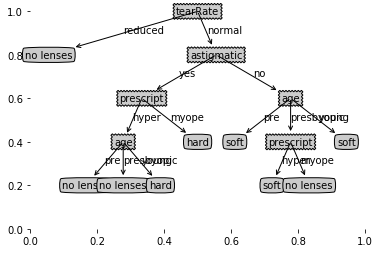

In [119]:
CreatePlot(lensesTree)